In [1]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from typing import Dict, Text

import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

2024-08-28 16:18:42.635343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 16:18:42.651069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 16:18:42.655770: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 16:18:42.668953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 16:18:43.652163: W tensorflow/compiler/tf2

## Preprocess

### Download Datasets

In [3]:
# Download the dataset and cache them as `tfrecord`

ratings_dataset, ratings_dataset_info = tfds.load(
    # Options: '25m-ratings', 'latest-small-ratings', '100k-ratings', '1m-ratings', '20m-ratings'
    name = 'movielens/100k-ratings',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)

movies_dataset, movies_dataset_info = tfds.load(
    # Options: '25m-movies', 'latest-small-movies', '100k-movies', '1m-movies', '20m-movies'
    name = 'movielens/100k-movies',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)

I0000 00:00:1724849325.849009  153666 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724849325.905625  153666 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724849325.905700  153666 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724849325.909437  153666 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724849325.909543  153666 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Feature Selection

In [4]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp'],
        # Target Variable
        'score': rating['user_rating']
    }
)

### Dataset Splitting

In [5]:
# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # The new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size = 100_000,
    # The random seed used to create the distribution.
    seed = RANDOM_STATE,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration = False
)

# Split dataset randomly (80% for training and 20% for validation)
trainset_size: int  = 0.8 * ratings_dataset.__len__().numpy()

ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
print(f"trainset_size:", ratings_trainset.__len__().numpy())

ratings_validset = ratings_dataset_shuffled.skip(trainset_size)
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [6]:
# Create implicit ratings for Retieval
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
        'movie_title': rating['movie_title'],
    }
)

In [7]:
from src.towers.query import QueryTower
from src.towers.candidate import CandidateTower
from src.rankings.pointwise import PointwiseRanking

candidate_tower = CandidateTower(
    dataset = ratings_trainset,
    embedding_dim = 4
)

query_tower = QueryTower(
    dataset = ratings_trainset,
    embedding_dim = 4
)

In [8]:
# Ranking
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError()
    ]
)
ranking_model = PointwiseRanking(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    task = ranking_task
)

In [10]:
ranking_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
ranking_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

# Ranking
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.1)
ranking_model.compile(optimizer = optimizer)
history = ranking_model.fit(
    ranking_ratings_trainset,
    validation_data = ranking_ratings_validset,
    validation_freq = 1,
    epochs = 100,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/100


I0000 00:00:1724851192.739786  153788 service.cc:146] XLA service 0x7f8424010c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724851192.740042  153788 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-28 16:49:52.747462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 16:49:52.775554: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724851192.851123  153788 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 20s 164ms/step - root_mean_squared_error: 0.0000e+00 - loss: 1.7223 - regularization_loss: 0.0000e+00 - total_loss: 1.7223 - val_root_mean_squared_error: 1.1399 - val_loss: 1.3265 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3265
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - root_mean_squared_error: 0.0000e+00 - loss: 1.0195 - regularization_loss: 0.0000e+00 - total_loss: 1.0195 - val_root_mean_squared_error: 0.9646 - val_loss: 0.9694 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9694
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - root_mean_squared_error: 0.0000e+00 - loss: 0.9065 - regularization_loss: 0.0000e+00 - total_loss: 0.9065 - val_root_mean_squared_error: 0.9574 - val_loss: 0.9685 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9685
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - root_mean_squared_error: 0.0000e+00 - loss: 0.8817 - regular

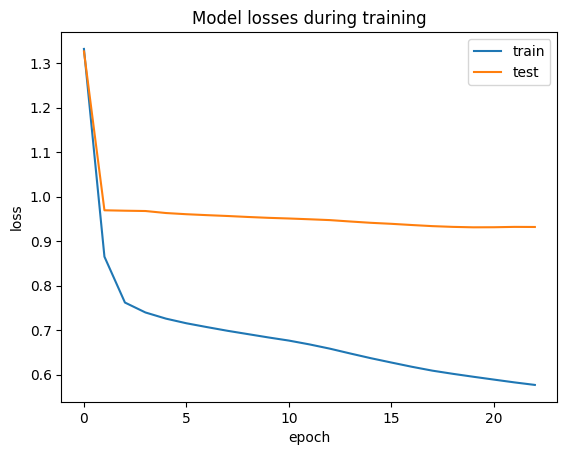

In [11]:
# Plot loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [12]:
movie_ids = ['1681', '1457', '500', '838', 'xxx']
for movie_id in movie_ids:
  pred = ranking_model({
      "user_id": tf.convert_to_tensor(["1"]),
      "movie_id": tf.convert_to_tensor([movie_id]),
      "movie_title": tf.convert_to_tensor(["God Father"])
  })
  print(f"Prediction for movie_id {movie_id}: {pred}")

Prediction for movie_id 1681: [[3.8276494]]
Prediction for movie_id 1457: [[3.8618286]]
Prediction for movie_id 500: [[4.40378]]
Prediction for movie_id 838: [[2.448929]]
Prediction for movie_id xxx: [[3.2560005]]
